## 3) Inestabilidades en flujos estratificados

> Haciendo uso del solver BOUSS en GHOST,
resuelva numéricamente las ecuaciones para un flujo incompresible con $ρ_0=1$,
en un recinto cubico de longitud $4π × 2π × 2π$
y resolución espacial $N_x=256$, $N_y=16$, $N_z=128$.
Hacer uso del Material Adicional.
Utilice como condición inicial el siguiente perfil para la velocidad horizontal
> $$ \frac{u}{u_0} = \tanh[γ(z − π/2)] + \tanh[γ(−z + 3π/2)] − 1 \tag{6} $$
> donde $γ$ controla la pendiente de la tangente hiperbólica,
y por lo tanto el gradiente de la velocidad inicial.
A la vez, perturbe este perfil con un campo de velocidad aleatorio con amplitud $u_1$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ghost_xarray import open_dataarray, open_dataset

### a)
> Grafique el perfil de la velocidad $u(z)$,
y calcule analíticamente el máximo número de Richardson en
función de la frecuencia de Brunt-Väisälä $N$ y de $γ$.

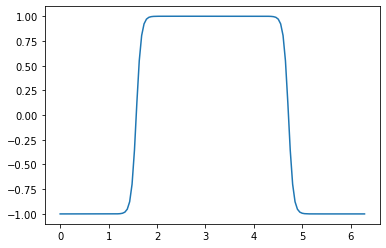

In [2]:
def initial_u(z, gamma):
    return np.tanh(gamma * (z - np.pi / 2)) + np.tanh(gamma * (-z + 3 * np.pi / 2)) - 1

z = np.linspace(0, 2 * np.pi, 128)
plt.plot(z, initial_u(z, 10))

### b)
> Calcule la resolución espacial $∆x$, $∆y$ y $∆z$.
¿Cómo justifica la elección de $∆y$ que resulta de los parámetros dados?
Para $u_0 = 1$ y asumiendo que $u_0 \gg u_1$,
estime $∆t$ usando la condición CFL.

In [3]:
L = 2 * np.pi * np.array([2, 1, 1])
N = np.array([256, 16, 128])

L / N

array([0.04908739, 0.39269908, 0.04908739])

Parámetros para el solver:

In [10]:
dt_CFL = 0.05
dt_solver = dt_CFL / 10

t_total = 10
N_steps = t_total / dt_solver

dt_save = 0.5
N_step_save = dt_save / dt_solver

Coordenadas y función para abrir simulaciones:

In [12]:
coords = {i: np.linspace(0, Li, Ni) for i, Li, Ni in zip("xyz", L, N)}

def open_simulation(name):
    return open_dataset(f"problema3/output/{name}", ["v", "th"], dt=dt_save, shape=coords, dtype=np.float32)

### c)
> Realice una simulación con
$u_0 = 1$,
$u_1 = 0.1$,
$ν = κ = 2 × 10^{-3}$,
$N = 2$ y
$γ = 10$
hasta $t = 10$.
Guarde el campo de velocidad y la temperatura para $∆t ≤ 0.6$.
Estudie la evolución temporal de $u$, $ω_y$ y de la temperatura $θ$.
¿Qué observa?

In [15]:
data = open_simulation("punto_c")
data

<xarray.Dataset>
Dimensions:  (x: 256, y: 16, z: 128, t: 21, i: 3)
Coordinates:
  * x        (x) float64 0.0 0.04928 0.09856 0.1478 ... 12.42 12.47 12.52 12.57
  * y        (y) float64 0.0 0.4189 0.8378 1.257 ... 5.027 5.445 5.864 6.283
  * z        (z) float64 0.0 0.04947 0.09895 0.1484 ... 6.135 6.184 6.234 6.283
  * t        (t) float64 0.0 0.5 1.0 1.5 2.0 2.5 ... 7.5 8.0 8.5 9.0 9.5 10.0
  * i        (i) object 'z' 'x' 'y'
Data variables:
    v        (i, t, x, y, z) float32 dask.array<chunksize=(1, 1, 256, 16, 128), meta=np.ndarray>
    th       (t, x, y, z) float32 dask.array<chunksize=(1, 256, 16, 128), meta=np.ndarray>

In [31]:
import napari

viewer = napari.Viewer()

In [50]:
for vi in data.v:
    viewer.add_image(vi.compute(), name=str(vi.i.to_numpy()), colormap="twilight_shifted")

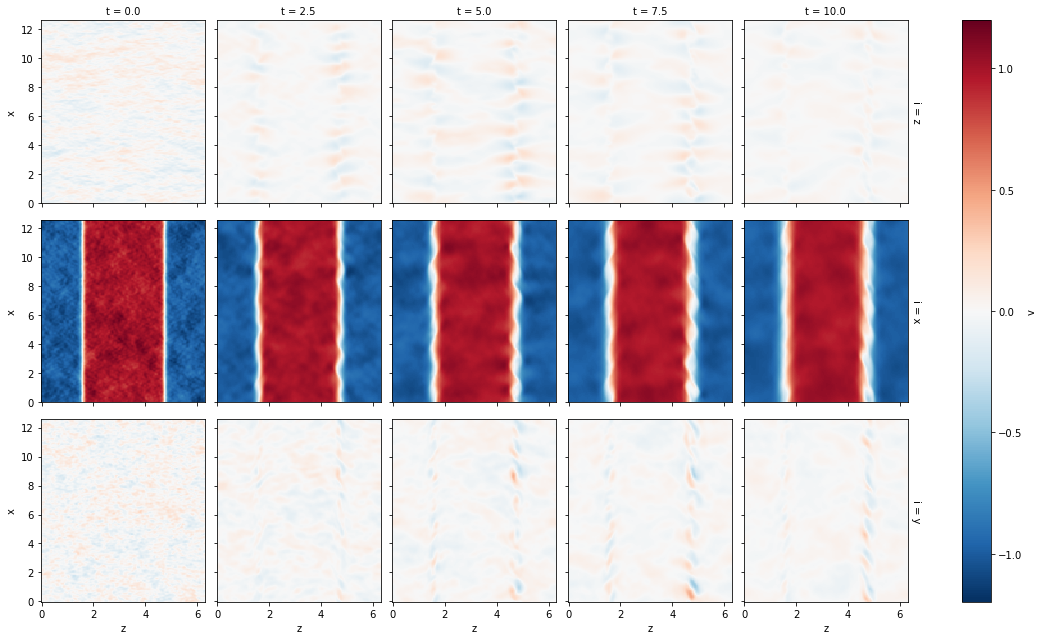

In [30]:
data.v.isel(y=8, t=slice(0, None, 5)).plot(col="t", row="i")

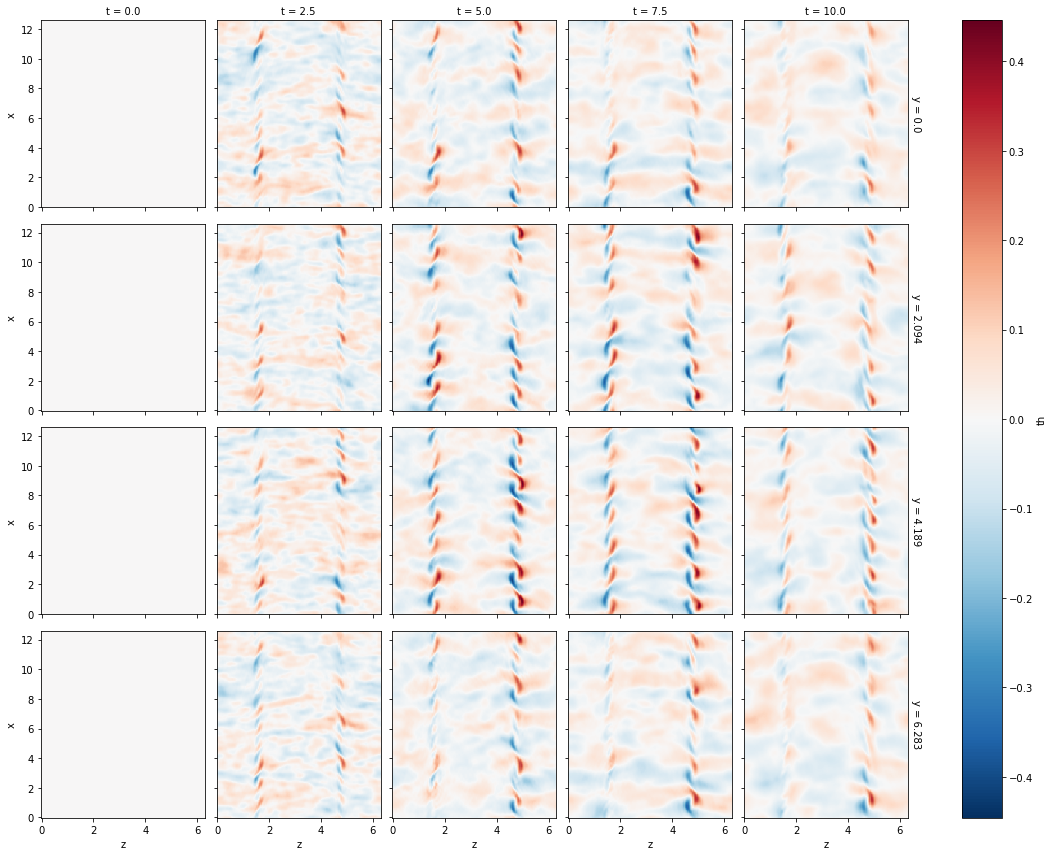

In [29]:
data.th.isel(y=slice(0, None, 5), t=slice(0, None, 5)).plot(col="t", row="y")

### d)
> Con los mismos parámetros del punto c),
realice ahora simulaciones variando $N$ entre $0$ y $6$ (pasos de a $1$).
¿Qué ocurre?
Estime la tasa de crecimiento de la inestabilidad
en función del máximo número de Richardson en el flujo.

### e)
> Con los mismos parámetros del punto c),
fije ahora $N = 2$
y varíe $γ$ entre $5$ y $20$ (pasos de a $5$).
Grafique el número de onda del modo más inestable
en función de $γ$
(ayuda: puede estimar este número de onda
contando cuantos máximos de la vorticidad $ω_y$ aparecen a lo largo de un corte horizontal
a medida que se desarrolla la inestabilidad)